In [158]:
import numpy as np
import random
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import dates
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from lmfit import minimize, Parameters, Parameter, report_fit
# Import libraries
import pandas as pd
import folium
import numpy as np
from urllib.request import urlopen
import json

In [159]:
with urlopen('https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson') as response:
    provs = json.load(response)
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv")
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
dfr = pd.read_csv(url,error_bad_lines=False)
dfr['data'] = pd.to_datetime(dfr['data'])
dfr['Days'] = (dfr.data.diff().dt.days+dfr.data.diff().dt.seconds/86400).cumsum().fillna(0).round(0)

In [160]:
df.rename(columns={'sigla_provincia':'prov_acr'},inplace=True)
last = df[df.data==df.data.max()].copy()
last['totale_casi'] = last['totale_casi']

In [165]:
last['totale_casi'].quantile([0.5, 0.75, 0.90, 0.95, 1])

0.50     238.5
0.75     741.5
0.90    1693.9
0.95    1985.7
1.00    8060.0
Name: totale_casi, dtype: float64

## Mappa aggiornata delle regioni colpite

In [168]:
bins = [0,200,1000,2000,4000,8000,10000]
# Initialize the map:
m = folium.Map(location=[42, 15], zoom_start=6)
 
# Add the color for the chloropleth:
choropleth = folium.Choropleth(
 geo_data=provs,
 name='choropleth',
 data=last,
 columns=['prov_acr', 'totale_casi'],
 key_on='properties.prov_acr',
 fill_color='Reds',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='totale_casi',
    bins=bins
).add_to(m)
m

## Dati degli ultimi 3 giorni

In [5]:
dfr[['data','terapia_intensiva','totale_attualmente_positivi','totale_casi','deceduti','Days']].tail(3)

data  terapia_intensiva  totale_attualmente_positivi  \
30 2020-03-25 17:00:00               3489                        57521   
31 2020-03-26 17:00:00               3612                        62013   
32 2020-03-27 17:00:00               3732                        66414   

    totale_casi  deceduti  Days  
30        74386      7503  30.0  
31        80539      8165  31.0  
32        86498      9134  32.0

# The SIR epidemic model

Il modello epidemiologico SIR individua tre categorie di persone:

- S(t) quelli che si possono ammalare
- I(t) gli infetti;
- R(t) quelli che hanno passato l'infezione e sono immuni (anche se morti).

Il modello ha due parametri:
- β che individua la frequenza di contatto effettiva tra le persone: un infetto viene a contatto con βN per unità di tempo. Di questi una frazione S/N può contrarre il virus
- γ che è la media del tempo di recupero: ossia 1/γ è il periodo medio in cui un infetto può trasmettere il virus. 

$$\frac{dS}{dt} = - \beta \frac{IS}{N} $$
$$\frac{dI}{dt} = \beta \frac{IS}{N} - \mu I$$
$$\frac{dR}{dt} = \gamma I$$

# 1.  $\beta$ dipendente dal tempo

Beta relationship: $$\beta = \beta*(1.1-0.0200*t)$$
$\beta_{low}$: 0.195<br>
$\beta_{high}$: 0.205<br>
$\gamma_{low}$: 1/8.5<br>
$\gamma_{high}$: 1/10<br>
$R_{0,low}$: 1.675<br>
$R_{0,high}$: 2.05<br>

In [6]:
def deriv_betarolling(y, t, N, beta, gamma,cf):
    S, I, R = y
    beta = beta*(1.10-cf*t)
    if beta <0:
        beta=0
        
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
# Total population, N.
N = 60e6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 221, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial conditions vector
y0 = S0, I0, R0

t = np.linspace(0, 70, 71)
beta_i = 0.37
gamma0 =  1./9

cf = 0.0200
SIR = pd.DataFrame(odeint(deriv_betarolling, y0, t, args=(N, beta_i, gamma0,cf)), columns=['S','I','R'])
SIR['Days'] = t

gamma0 = 1/8
cf = 0.02025
SIRlow = pd.concat([SIR,pd.DataFrame(odeint(deriv_betarolling, y0, t, args=(N, beta_i, gamma0,cf)), columns=['S_low','I_low','R_low'])],axis=1)

gamma0 = 1/10
cf = 0.01975
SIRup = pd.concat([SIRlow,pd.DataFrame(odeint(deriv_betarolling, y0, t, args=(N, beta_i, gamma0,cf)), columns=['S_sup','I_sup','R_sup'])],axis=1)

SIRup['date'] =pd.date_range(dfr.data.min(), periods=SIRup.shape[0], freq='D')
SIRup['Tot'] = SIRup['I']+SIRup['R']
SIRup['Tot_low'] = SIRup['I_low']+SIRup['R_low']
SIRup['Tot_sup'] = SIRup['I_sup']+SIRup['R_sup']
label_std = 'Sim.'+r' $ \beta $ = $ \beta $*(1.1-0.02), $\gamma$ = 1/9'
label_low = 'Sim.'+r' $ \beta $ = $ \beta $*(1.1-0.02),$\gamma$ = 1/8'
t2=SIRup.Days
I2=SIRup.I

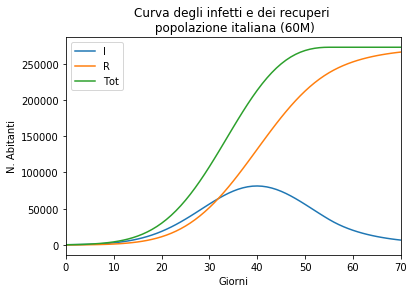

In [7]:
SIRup[['I','R','Tot']].plot()
plt.title('Curva degli infetti e dei recuperi \n popolazione italiana (60M)')
plt.ylabel('N. Abitanti')
plt.xlabel('Giorni');

Usando come valori $\beta$ = 0.37 e $\gamma$ = 1./9 il modello predice un totale di colpiti dall'epidemia di circa 250 mila individui. Sulla popolazione della lombardia significa il 2.5%. <br>

In [8]:
dfr['Hosp_R'] = dfr['totale_ospedalizzati']/dfr['totale_casi']
dfr['IC_R'] = dfr['terapia_intensiva']/dfr['totale_casi']
# Ratio of dead people over total cases
dfr['DR'] = dfr['deceduti']/dfr['totale_casi']

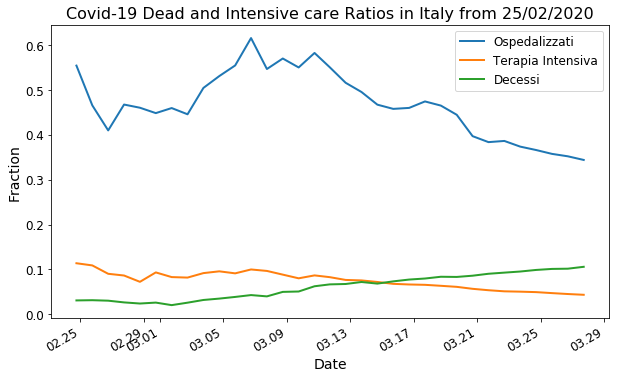

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
fig.autofmt_xdate()
sns.lineplot(x='data',y='Hosp_R', data=dfr, label='Ospedalizzati', ax=ax, lw=2)
sns.lineplot(x='data',y='IC_R', data=dfr, label='Terapia Intensiva', ax=ax, lw=2)
sns.lineplot(x='data',y='DR', data=dfr, label='Decessi', ax=ax, lw=2)
plt.ylabel('Fraction', fontsize=14)
plt.xlabel('Date', fontsize=14)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title('Covid-19 Dead and Intensive care Ratios in Italy from 25/02/2020', fontsize=16);

Dai dati ufficiali circa il 40% della popolazione viene ricoverato. La frazione che va in terapia intensiva si sta abbassando: inizialmente era al 10% mentre ora siamo sotto il 5%. <br>
Questi numeri sono più affidabili della frazione dei decessi che dipende dal numero totale di contagiati e la stima ufficiale è molto più bassa del numero probabile. Dalla letteratura straniera sappiamo che circa il 20% dei contagiati viene ricoverato e di questi il 10% sviluppa complicazioni che rendono necessaria la terapia intensiva. Mentre la mortalità in Cina si è attestata attorno al 3% (sempre rispetti ai casi riscontrati).
Tutti i numeri sono relativi al totale dei casi riportati.

### Il best fit è stato ottenuto il 14/03 e da allora lasciato invariato

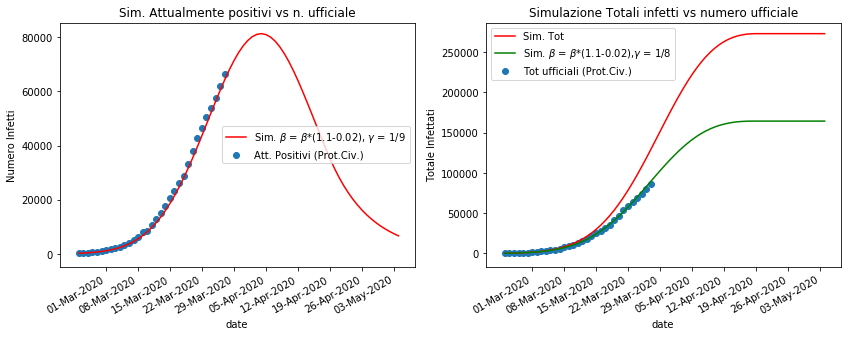

In [16]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
fig.autofmt_xdate()

sns.lineplot(x='date',y=SIRup.I,data=SIRup, label=label_std, color='red', ax=ax[0]);
ax[0].scatter(x=dfr['data'], y=dfr['totale_attualmente_positivi'], label='Att. Positivi (Prot.Civ.)')
ax[0].set(xticks=pd.date_range(dfr.data.min(), periods=SIRup.shape[0]/7, freq='W'))
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"))
ax[0].legend()
ax[0].set_title('Sim. Attualmente positivi vs n. ufficiale');
ax[0].set_ylabel('Numero Infetti')

sns.lineplot(x='date',y=SIRup.Tot,data=SIRup, label='Sim. Tot', color='red' ,ax=ax[1]);
sns.lineplot(x='date',y=SIRup.Tot_low,data=SIRup, label=label_low, color='green' ,ax=ax[1]);
ax[1].scatter(x=dfr['data'], y=dfr['totale_casi'], label='Tot ufficiali (Prot.Civ.)')
ax[1].set(xticks=pd.date_range(dfr.data.min(), periods=SIRup.shape[0]/7, freq='W'))
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"))
ax[1].set_ylabel('Totale Infettati')
ax[1].legend()

plt.title('Simulazione Totali infetti vs numero ufficiale');

Da questi trend pare chiaro che si tiene in considerazione uno degli indicatori gli altri saranno da rivedere. In particolare la curva dei totali ufficiali risulta sottostimata. Il fit sui casi totali si ha modificando il parametro gamma da 9 giorni a 8. <br>
Sia $\beta$ che $\gamma$ risentono delle misure adottate di social distancing, ma forse su una scala di tempi diversa.

## Previsione con data dal giorno precedente:

In [17]:
import dateutil.relativedelta as relativedelta
today = pd.Timestamp(datetime.today().date()- relativedelta.relativedelta(days=1))
np.round(SIRup[SIRup.date>=today][['date','I_low','I','I_sup','R','Tot']],0).head()

date    I_low        I     I_sup        R       Tot
32 2020-03-27 18:00:00  39466.0  64477.0   96369.0  65076.0  129553.0
33 2020-03-28 18:00:00  41004.0  68124.0  103252.0  72445.0  140569.0
34 2020-03-29 18:00:00  42284.0  71445.0  109818.0  80202.0  151647.0
35 2020-03-30 18:00:00  43279.0  74375.0  115949.0  88307.0  162682.0
36 2020-03-31 18:00:00  43966.0  76854.0  121529.0  96713.0  173567.0

## Previsione data del massimo di infetti

In [68]:
np.round(SIRup[(SIRup.Days<90)&(SIRup.I>100)&(SIRup.I==SIRup.I.max())][['date','I_low','I','I_sup','Tot','Days']],0)

date    I_low        I     I_sup       Tot  Days
40 2020-04-04 18:00:00  43446.0  81372.0  136321.0  213586.0  40.0

## Previsione data del massimo contagiati

In [19]:
np.round(SIRup[(SIRup.Days<100)&(SIRup.Tot==SIRup.Tot.max())][['date','I_low','I','I_sup','Tot']],0)

date    I_low        I    I_sup       Tot
55 2020-04-19 18:00:00  14338.0  35215.0  74280.0  272928.0

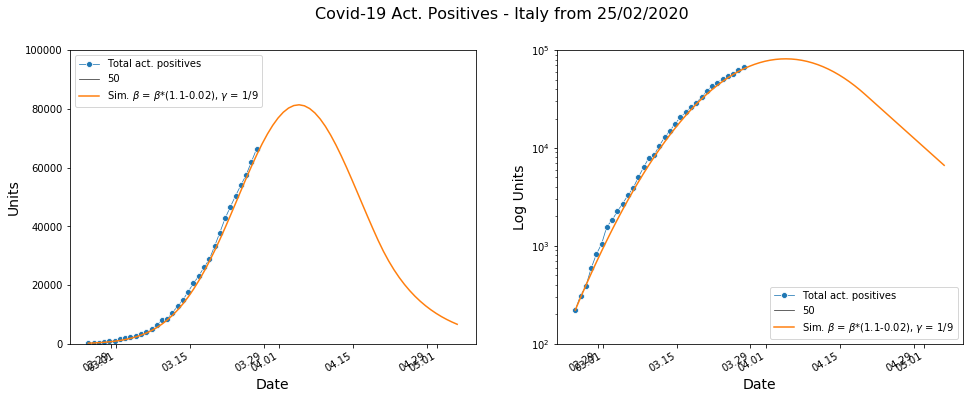

In [20]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.autofmt_xdate()

i=0
for axx in ax:
    sns.lineplot(x='data',y='totale_attualmente_positivi', data=dfr, label='Total act. positives', lw=2, marker="o", size=50,legend='full',ax=ax[i])
    sns.lineplot(x='date',y='I', data=SIRup[(SIRup.Days<90)&(SIRup.I>100)], label=label_std,ax=ax[i])
    ax[i].set_ylabel('Units', fontsize=14)
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
    ax[i].set_ylim(0,100000)
    if i==1:
        ax[i].set_yscale('log')
        ax[i].set_ylim(100,100000)
        ax[i].set_ylabel('Log Units', fontsize=14)
    i+=1
plt.suptitle('Covid-19 Act. Positives - Italy from 25/02/2020', fontsize=16);

## Previsione con bande di errore
- un buon fit sugli attualmente positivi porta a sovrastimare il totale e viceversa.

In [86]:
def sir_bounds(y, t, N, beta, gamma, cf,cond,yday,cf_low,cf_sup):
    S, I, R = y
    if t<= yday:
        beta = beta_i*(1.10-cf*t)
    else:
        if cond=='std':
            beta = beta_i*(1.10-cf*t)
        elif cond=='low':
            beta = beta_i*(1.10-cf_low*t)
            gamma = 1/8
        else:
            beta = beta_i*(1.10-cf_sup*t)
            gamma = 1/10
            
    if beta <0:
        beta=0
        
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# Total population, N.
N = 60e6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 221, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial conditions vector
y0 = S0, I0, R0
t = np.linspace(0, 70, 71)

yday  = dfr.Days.max()-2
beta_i = 0.37
gamma0 =  1./9
cf = 0.0200
cf_low = 0.02025
cf_sup = 0.0195

result = pd.DataFrame()
result['Days'] = t

for cond in ['std','low','sup']:
    temp = pd.DataFrame(odeint(sir_bounds, y0, t, args=(N, beta_i, gamma0,cf,cond,yday,cf_low,cf_sup)), columns=['S'+cond,'I'+cond,'R'+cond])
    result = pd.concat([result,temp],axis=1)
result['date'] =pd.date_range(dfr.data.min(), periods=result.shape[0], freq='D')
result['Tot'] = result['Istd']+result['Rstd']
result['Tot_low'] = result['Ilow']+result['Rlow']
result['Tot_sup'] = result['Isup']+result['Rsup']

In [87]:
label_std = 'Sim.'+r' $ \beta $ = $ \beta $*(1.1-0.02)'#', $\gamma$ = 1/9'
label_low = 'Sim.'+r' $ \beta $ = $ \beta $*(1.1-0.02)'#',$\gamma$ = 1/8'
t2=result.Days
I2=result.Istd

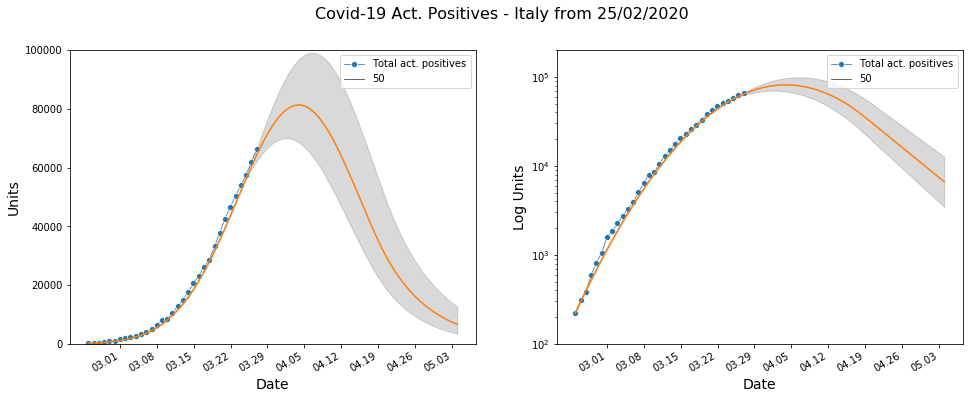

In [88]:
plotdata = result[(result.Days<90)&(result.Istd>100)][['Istd','Ilow','Isup','Days','date']].copy()
plotdata.index = plotdata.date

fc_series = pd.Series(plotdata['Istd'])
lower_series = pd.Series(plotdata['Ilow'])
upper_series = pd.Series(plotdata['Isup'])

fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.autofmt_xdate()

i=0
for axx in ax:
    sns.lineplot(x='data',y='totale_attualmente_positivi', data=dfr, label='Total act. positives', lw=2, marker="o", size=50,legend='full',ax=ax[i])
    ax[i].plot(fc_series, label='forecast')
    ax[i].fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    ax[i].set_ylabel('Units', fontsize=14)
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[i].set(xticks=pd.date_range(plotdata.date.min(), periods=fc_series.shape[0]/7, freq='W'))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
    ax[i].set_ylim(0,100000)
    if i==1:
        ax[i].set_yscale('log')
        ax[i].set_ylim(100,200000)
        ax[i].set_ylabel('Log Units', fontsize=14)
    i+=1
plt.suptitle('Covid-19 Act. Positives - Italy from 25/02/2020', fontsize=16);

# Simulazione interruzione Social Distancing/quarantena

Rispetto all'andamento mostrato prima qui vediamo cosa succede nel caso di un ritorno improvviso alle normali attività in 3 punti della curva ogni 10 giorni a partire dal giorno dopo il massimo 05/04, il 15/04 e il 25/04.

In [148]:
def sir_forecast(y, t, N, beta_i, gamma, cf,day):
    S, I, R = y

    beta = beta_func(beta_i,cf,t,day)
    
    #print(t,beta)    
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def beta_func(beta_i, cf,t, day):
    if t<= day:
        beta = beta_i*(1.10-cf*t) 
    else:
        beta = beta_i
    if beta <0:
        beta=0
        
    return beta

# Total population, N.
N = 60e6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 221, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial conditions vector
y0 = S0, I0, R0
t = np.linspace(0, 120, 121)

beta_i = 0.37
gamma0 =  1./9
cf = 0.0200

Stop = pd.DataFrame()
Stop['Days'] = t

for day in [41,51,61,71]:
    temp = pd.DataFrame(odeint(sir_forecast, y0, t, args=(N, beta_i, gamma0,cf,day)), columns=['S'+str(day),'I'+str(day),'R'+str(day)])
    Stop = pd.concat([Stop,temp],axis=1)
    Stop['R_0'+str(day)] = Stop.Days.apply(lambda x: beta_func(beta_i,cf,x,day)) /gamma0
    Stop['date'] =pd.date_range(dfr.data.min(), periods=Stop.shape[0], freq='D')
    Stop['Tot_'+str(day)] = Stop['I'+str(day)]+Stop['R'+str(day)]

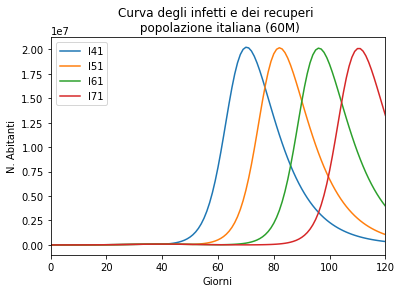

In [149]:
Stop.filter(like='I').plot()
plt.title('Curva degli infetti e dei recuperi \n popolazione italiana (60M)')
plt.ylabel('N. Abitanti')
plt.xlabel('Giorni');

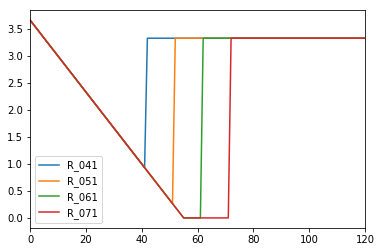

In [150]:
Stop.filter(like='R_0').plot()

In [153]:
dfr.head(1)

data stato  ricoverati_con_sintomi  terapia_intensiva  \
0 2020-02-24 18:00:00   ITA                     101                 26   

   totale_ospedalizzati  isolamento_domiciliare  totale_attualmente_positivi  \
0                   127                      94                          221   

   nuovi_attualmente_positivi  dimessi_guariti  deceduti  totale_casi  \
0                         221                1         7          229   

   tamponi note_it note_en  Days    Hosp_R      IC_R        DR  
0     4324     NaN     NaN   0.0  0.554585  0.113537  0.030568

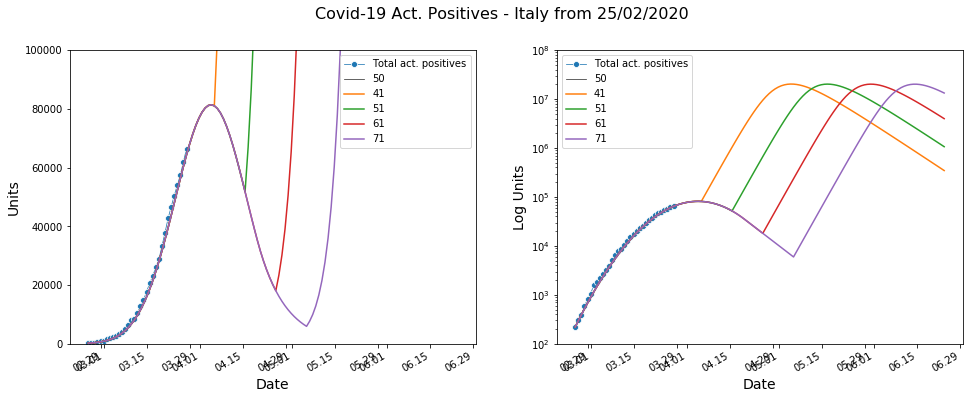

In [154]:
#label_sim= 'Sim.'+r'$\beta = \beta_i*(1.10-cf*day+cf/2*t)$ dopo giorni'
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.autofmt_xdate()

i=0
for axx in ax:
    sns.lineplot(x='data',y='totale_attualmente_positivi', data=dfr, label='Total act. positives', lw=2, marker="o", size=50,legend='full',ax=ax[i])
    sns.lineplot(x='date',y='I41',data=Stop[(Stop.I41>100)], label='41',ax=ax[i])
    sns.lineplot(x='date',y='I51',data=Stop[(Stop.I41>100)], label='51',ax=ax[i])
    sns.lineplot(x='date',y='I61',data=Stop[(Stop.I41>100)], label='61',ax=ax[i])
    sns.lineplot(x='date',y='I71',data=Stop[(Stop.I41>100)], label='71',ax=ax[i])
    ax[i].set_ylabel('Units', fontsize=14)
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
    ax[i].set_ylim(0,100000)
    if i==1:
        ax[i].set_yscale('log')
        ax[i].set_ylim(100,1e8)
        ax[i].set_ylabel('Log Units', fontsize=14)
    i+=1
plt.suptitle('Covid-19 Act. Positives - Italy from 25/02/2020', fontsize=16);

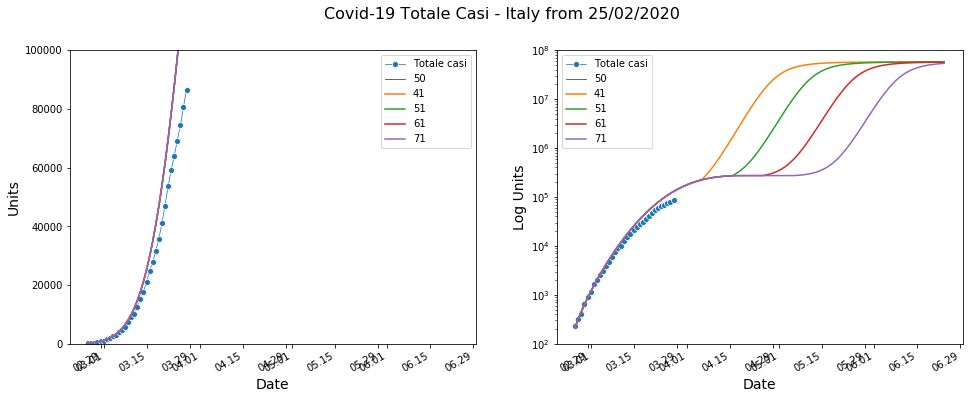

In [156]:
#label_sim= 'Sim.'+r'$\beta = \beta_i*(1.10-cf*day+cf/2*t)$ dopo giorni'
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.autofmt_xdate()

i=0
for axx in ax:
    sns.lineplot(x='data',y='totale_casi', data=dfr, label='Totale casi', lw=2, marker="o", size=50,legend='full',ax=ax[i])
    sns.lineplot(x='date',y='Tot_41',data=Stop[(Stop.I41>100)], label='41',ax=ax[i])
    sns.lineplot(x='date',y='Tot_51',data=Stop[(Stop.I41>100)], label='51',ax=ax[i])
    sns.lineplot(x='date',y='Tot_61',data=Stop[(Stop.I41>100)], label='61',ax=ax[i])
    sns.lineplot(x='date',y='Tot_71',data=Stop[(Stop.I41>100)], label='71',ax=ax[i])
    ax[i].set_ylabel('Units', fontsize=14)
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
    ax[i].set_ylim(0,100000)
    if i==1:
        ax[i].set_yscale('log')
        ax[i].set_ylim(100,1e8)
        ax[i].set_ylabel('Log Units', fontsize=14)
    i+=1
plt.suptitle('Covid-19 Totale Casi - Italy from 25/02/2020', fontsize=16);

Dagli andamenti riportati è evidente che non è importante tanto quanto dura la quarantena ma quanto siamo in grado di prevenire il contagio adottando misure di prevenzione e non di curare solo chi si ammala.<br>
Con un bacino di popolazione non immune di 60 milioni di persone bastano altre persone contagiate per diffonderlo con la stessa rapidità che abbiamo visto a fine febbraio.

In [191]:
def sir_forecast(y, t, N, beta_i, gamma, cf,day):
    S, I, R = y

    beta = beta_func(beta_i,cf,t,day)
    
    #print(t,beta)    
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def beta_func(beta_i, cf,t, day):
    if t<= day:
        beta = beta_i*(1.10-cf*t) 
    elif t<=day+3:
        beta = beta_i
            
    else:
        beta = beta_i*(1.10-cf*(t-day))
        
    if beta <0:
        beta=0

        
    return beta

# Total population, N.
N = 60e6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 221, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial conditions vector
y0 = S0, I0, R0
t = np.linspace(0, 120, 121)

beta_i = 0.37
gamma0 =  1./9
cf = 0.0200
day=61

Stop2 = pd.DataFrame()
Stop2['Days'] = t

for day in [41,51,61,71]:
    temp = pd.DataFrame(odeint(sir_forecast, y0, t, args=(N, beta_i, gamma0,cf,day)), columns=['S'+str(day),'I'+str(day),'R'+str(day)])
    Stop2 = pd.concat([Stop2,temp],axis=1)
    Stop2['R_0'+str(day)] = Stop2.Days.apply(lambda x: beta_func(beta_i,cf,x,day)) /gamma0
    Stop2['date'] =pd.date_range(dfr.data.min(), periods=Stop2.shape[0], freq='D')
    Stop2['Tot_'+str(day)] = Stop2['I'+str(day)]+Stop2['R'+str(day)]

# Secondo outbreak con nuovo stop attività dopo 61 giorni

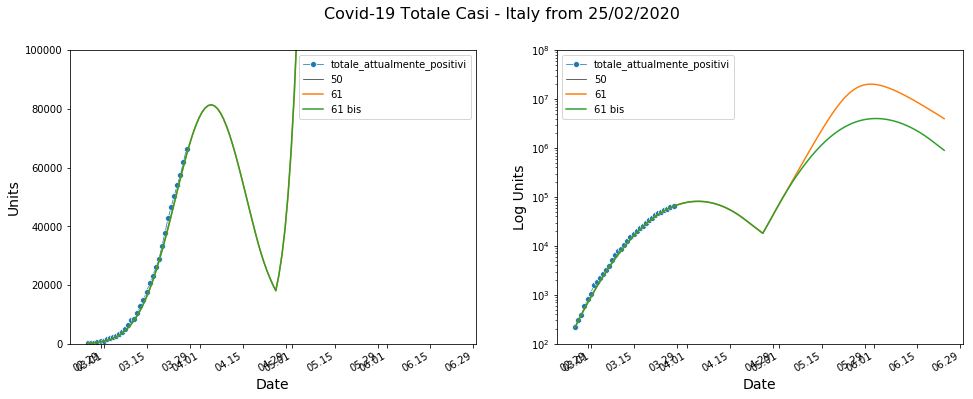

In [192]:
#label_sim= 'Sim.'+r'$\beta = \beta_i*(1.10-cf*day+cf/2*t)$ dopo giorni'
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.autofmt_xdate()

i=0
for axx in ax:
    sns.lineplot(x='data',y='totale_attualmente_positivi', data=dfr, label='totale_attualmente_positivi', lw=2, marker="o", size=50,legend='full',ax=ax[i])
    sns.lineplot(x='date',y='I61',data=Stop[(Stop.I41>100)], label='61',ax=ax[i])
    sns.lineplot(x='date',y='I61',data=Stop2[(Stop2.I41>100)], label='61 bis',ax=ax[i])
    ax[i].set_ylabel('Units', fontsize=14)
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
    ax[i].set_ylim(0,100000)
    if i==1:
        ax[i].set_yscale('log')
        ax[i].set_ylim(100,1e8)
        ax[i].set_ylabel('Log Units', fontsize=14)
    i+=1
plt.suptitle('Covid-19 Totale Casi - Italy from 25/02/2020', fontsize=16);